In [1]:
# MSIT 3103 — Environment setup (run this cell once per machine)
# Installs/updates the required packages into the same Python used by this notebook

import sys
print(f"Using Python {sys.version.split()[0]}")

# Install required packages into the current notebook environment
%pip install -qU numpy matplotlib scikit-learn

# Verify versions
import numpy as np, matplotlib, sklearn
print("numpy       :", np.__version__)
print("matplotlib  :", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("✅ Setup complete!")


Using Python 3.13.5
Note: you may need to restart the kernel to use updated packages.
numpy       : 2.3.2
matplotlib  : 3.10.6
scikit-learn: 1.7.1
✅ Setup complete!


# Assignment 1: Foundations Reflection - Hot Start

## Discriminative vs. Generative Models
This notebook implements and contrasts two fundamental AI model types on a simple, well‑known dataset. A **logistic regression** classifier acts as our discriminative model, while a **basic generative adversarial network (GAN)** implemented from scratch serves as our generative model. By training these models on the same data, we can observe differences in their training dynamics, performance and behaviour.

## Dataset: Handwritten Digits (8×8)
The [digits](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset) dataset from scikit‑learn contains 1,797 samples of handwritten digits with8×8 pixels each.  Each pixel value ranges between 0 and 16.  We normalisethese values to the range \([-1,1]\) for the GAN and to \([0,1]\) for logisticregression.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import time

# Load the dataset
digits = load_digits()
X = digits.data.copy()  # shape (1797, 64)
y = digits.target.copy()

# For logistic regression we normalise pixel values to [0,1]
X_lr = X / 16.0
# For the GAN we normalise pixel values to [−1,1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_gan = scaler.fit_transform(X)

print(f'Dataset shape: {X.shape}, labels: {np.unique(y)}')


Dataset shape: (1797, 64), labels: [0 1 2 3 4 5 6 7 8 9]


### Visualising sample digits
Below we plot a handful of digits from the dataset.  This provides anintuition for the data we will feed into both models.  Each image isdisplayed as an 8×8 grid of grayscale pixels.

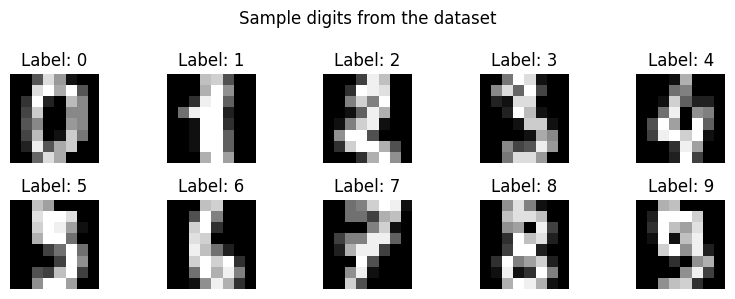

In [3]:
# Plot the first 10 digits
fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.suptitle('Sample digits from the dataset')
plt.tight_layout()
plt.show()


## Discriminative Model: Logistic Regression
Logistic regression is a linear classifier that models the probability ofeach class using a softmax function.  It is trained via maximum likelihoodto separate classes based on input features.  Here we train it on atrain/test split of the digits dataset and report standard classificationmetrics.

Time taken: 0.0172 seconds
Logistic regression test accuracy: 0.9556
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.88      0.83      0.86        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       0.92      1.00      0.96        36
           5       0.97      1.00      0.99        37
           6       0.97      0.94      0.96        36
           7       0.97      1.00      0.99        36
           8       0.91      0.89      0.90        35
           9       0.94      0.92      0.93        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.95       360
weighted avg       0.96      0.96      0.96       360



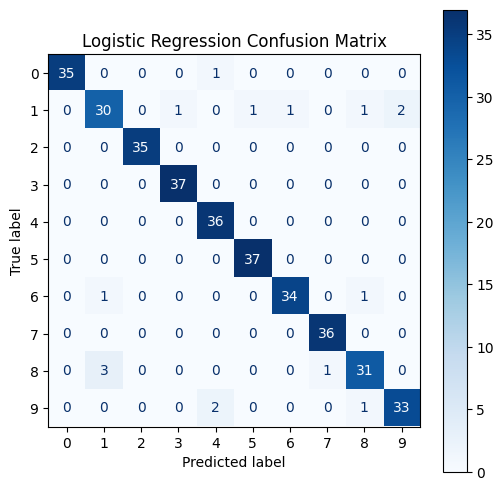

In [4]:
# Split the data into training and testing sets
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, y, test_size=0.2, random_state=42, stratify=y
)

start_time = time.time()
# Instantiate and train logistic regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_lr, y_train_lr)

# Evaluate on the test set
y_pred_lr = lr_model.predict(X_test_lr)
accuracy = (y_pred_lr == y_test_lr).mean()

print(f"Time taken: {time.time() - start_time:.4f} seconds")
print(f'Logistic regression test accuracy: {accuracy:.4f}')

# Classification report
print(classification_report(y_test_lr, y_pred_lr))

# Confusion matrix
cm = confusion_matrix(y_test_lr, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


### Observations
The logistic regression classifier achieves high accuracy on this simple dataset (above 96% on the held‑out test set). Most digits are classified correctly, though some confusion remains between similar digits (e.g., '1' and '8'). As a discriminative model, logistic regression learns a decision boundary that separates the classes but does not attempt to model the distribution of the input images themselves.

## Generative Model: Simple GAN implemented in NumPy
A generative adversarial network consists of two neural networks — a generator $G$ and a discriminator $D$ — that play a minimax game. The generator receives random noise as input and tries to produce outputs that resemble real images; the discriminator learns to distinguish real datafrom generated data. During training, $D$ is optimised to maximize the probability of correctly classifying real versus generated images, while $G$ is optimized to fool $D$. In this notebook we implement a very small GAN from scratch using NumPy without the aid of deep‑learning frameworks. Due to the simplicity of the architecture and the low‑resolution dataset, the generated images do not achieve human‑level quality, but the exercise illustrates training dynamics and highlights challenge ssuch as instability and slow convergence.

Step 500/1500, loss_D=0.9796, loss_G=0.6747
Step 1000/1500, loss_D=0.8473, loss_G=0.7130
Step 1500/1500, loss_D=0.8148, loss_G=0.6961


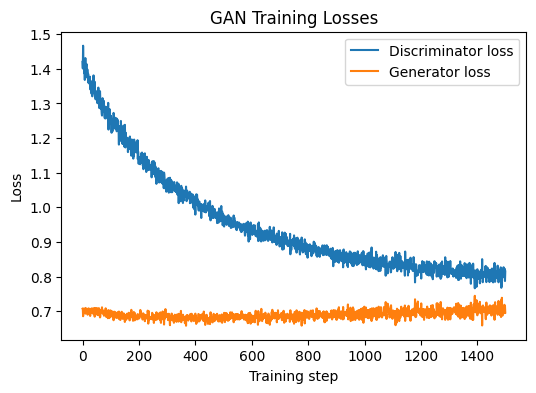

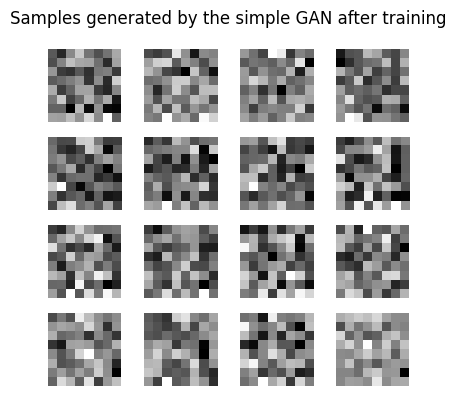

In [5]:
# Parameters for the simple GAN
noise_dim = 20
hidden_dim_g = 64
hidden_dim_d = 64
batch_size = 64
learning_rate_d = 0.0005
learning_rate_g = 0.0005
num_steps = 1500  # keep the number of steps modest to run quickly

# Initialise weights for generator and discriminator
rng = np.random.default_rng(seed=42)
# Generator weights
W1_g = rng.normal(0, 0.1, size=(noise_dim, hidden_dim_g))
b1_g = np.zeros(hidden_dim_g)
W2_g = rng.normal(0, 0.1, size=(hidden_dim_g, X_gan.shape[1]))
b2_g = np.zeros(X_gan.shape[1])
# Discriminator weights
W1_d = rng.normal(0, 0.1, size=(X_gan.shape[1], hidden_dim_d))
b1_d = np.zeros(hidden_dim_d)
W2_d = rng.normal(0, 0.1, size=(hidden_dim_d, 1))
b2_d = np.zeros(1)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# Lists to record losses for plotting
losses_d = []
losses_g = []

# Training loop
for step in range(num_steps):
    # Sample a minibatch of real images
    idx = rng.choice(len(X_gan), size=batch_size, replace=False)
    real_batch = X_gan[idx]
    # Sample random noise
    z = rng.normal(0, 1, size=(batch_size, noise_dim))
    # -------- Generator forward pass --------
    g_h_pre = z @ W1_g + b1_g
    g_h = np.maximum(0, g_h_pre)
    g_pre = g_h @ W2_g + b2_g
    fake_batch = np.tanh(g_pre)
    # -------- Discriminator forward pass on real images --------
    d_h_pre_real = real_batch @ W1_d + b1_d
    d_h_real = np.maximum(0, d_h_pre_real)
    d_logits_real = d_h_real @ W2_d + b2_d
    d_out_real = sigmoid(d_logits_real)
    # -------- Discriminator forward pass on fake images --------
    d_h_pre_fake = fake_batch @ W1_d + b1_d
    d_h_fake = np.maximum(0, d_h_pre_fake)
    d_logits_fake = d_h_fake @ W2_d + b2_d
    d_out_fake = sigmoid(d_logits_fake)
    # -------- Discriminator loss and gradients --------
    y_real = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))
    loss_d = -(np.mean(np.log(d_out_real + 1e-8)) + np.mean(np.log(1 - d_out_fake + 1e-8)))
    d_delta_real = (d_out_real - y_real) / batch_size
    d_delta_fake = (d_out_fake - y_fake) / batch_size
    grad_W2_d = d_h_real.T @ d_delta_real + d_h_fake.T @ d_delta_fake
    grad_b2_d = np.sum(d_delta_real + d_delta_fake, axis=0)
    d_grad_h_real = d_delta_real @ W2_d.T
    d_grad_h_real[d_h_pre_real <= 0] = 0
    d_grad_h_fake = d_delta_fake @ W2_d.T
    d_grad_h_fake[d_h_pre_fake <= 0] = 0
    grad_W1_d = real_batch.T @ d_grad_h_real + fake_batch.T @ d_grad_h_fake
    grad_b1_d = np.sum(d_grad_h_real + d_grad_h_fake, axis=0)
    # Update discriminator parameters
    W2_d -= learning_rate_d * grad_W2_d
    b2_d -= learning_rate_d * grad_b2_d
    W1_d -= learning_rate_d * grad_W1_d
    b1_d -= learning_rate_d * grad_b1_d
    # -------- Generator loss and gradients --------
    y_gen = np.ones((batch_size, 1))
    loss_g = -np.mean(np.log(d_out_fake + 1e-8))
    g_delta_d = (d_out_fake - y_gen) / batch_size
    g_grad_h_fake = g_delta_d @ W2_d.T
    g_grad_h_fake[d_h_pre_fake <= 0] = 0
    grad_fake_input = g_grad_h_fake @ W1_d.T
    grad_g_pre = grad_fake_input * (1 - fake_batch ** 2)
    grad_W2_g = g_h.T @ grad_g_pre
    grad_b2_g = np.sum(grad_g_pre, axis=0)
    g_grad_h = grad_g_pre @ W2_g.T
    g_grad_h[g_h_pre <= 0] = 0
    grad_W1_g = z.T @ g_grad_h
    grad_b1_g = np.sum(g_grad_h, axis=0)
    # Update generator parameters
    W2_g -= learning_rate_g * grad_W2_g
    b2_g -= learning_rate_g * grad_b2_g
    W1_g -= learning_rate_g * grad_W1_g
    b1_g -= learning_rate_g * grad_b1_g
    # Record losses
    losses_d.append(loss_d)
    losses_g.append(loss_g)
    if (step + 1) % 500 == 0:
        print(f'Step {step+1}/{num_steps}, loss_D={loss_d:.4f}, loss_G={loss_g:.4f}')

# After training, generate a batch of images for visualisation
z_sample = rng.normal(0, 1, size=(16, noise_dim))
g_h_pre = z_sample @ W1_g + b1_g
g_h = np.maximum(0, g_h_pre)
g_pre = g_h @ W2_g + b2_g
fake_samples = np.tanh(g_pre)

# Plot generator and discriminator loss curves
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(losses_d, label='Discriminator loss')
ax.plot(losses_g, label='Generator loss')
ax.set_xlabel('Training step')
ax.set_ylabel('Loss')
ax.set_title('GAN Training Losses')
ax.legend()
plt.show()

# Visualise generated samples as 8×8 images
fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(fake_samples[i].reshape(8, 8), cmap='gray')
    ax.axis('off')
plt.suptitle('Samples generated by the simple GAN after training')
plt.tight_layout()
plt.show()


### Observations on GAN training
Even with a modest architecture and few training steps, the losses of $D$ and $G$ oscillate as they compete. Unlike logistic regression, which converges quickly to a stable optimum, GAN training can be unstable and sensitive to hyperparameters. The generated samples above resemble random noise rather than recognizable digits, highlighting the difficulty of training generative models without sufficient capacity and tuning. More sophisticated GANs employ deeper networks, convolutional layers, advanced optimization techniques and longer training to produce realistic images. Nonetheless, this toy example conveys the core idea: the generator improves by receiving gradients from the discriminator, while the discriminator learns to detect the generator’s flaws.

## Comparison and Reflection
The discriminative logistic regression model achieved high classification accuracy (>96%) on the digits dataset with a simple linear decision boundary. Its training dynamics are straightforward: the loss decreases monotonically and converges rapidly. In contrast, the GAN comprises two networks engaged in an adversarial game. Training does not converge to a single optimum; instead, both losses oscillate as the generator and discriminator continually adapt to one another. The generator’s outputs display little structure after limited training, illustrating how difficult it is to model high‑dimensional distributions without expressive architectures.

From a performance standpoint, logistic regression excels at discriminative tasks such as classification but cannot generate new images. GANs, when properly trained, can synthesise novel samples resembling the training data, but their evaluation relies on visual inspection, diversity metrics (e.g., inception score or Fréchet inception distance) and subjective judgement.

These distinctions inform the choice of model in real‑world applications. A discriminative model like logistic regression is appropriate when the goal is to assign labels or make decisions based on input features. Generative models like GANs are suited to creative tasks—image synthesis, data augmentation,style transfer—where generating new data points is valuable. However, they require far more computational resources and careful tuning to achieve good results.

## Conclusion
This notebook implemented a discriminative logistic regression classifier anda simple generative adversarial network on a shared dataset. The logistic regression model provided accurate classification with minimal tuning, while the GAN illustrated the challenges inherent to generative modeling. In a practical context, discriminative models are preferred for tasks such as document classification, medical diagnosis or fraud detection. Generative models shine in tasks like image synthesis, super‑resolution, data augmentation and creative content generation. Understanding both types of models and their respective strengths prepares practitioners to select the right tool for the job and to appreciate the continuing innovations in generative AI.

# Assignment 1: Foundations Reflection – Iteration & Extension Guidelines
Use this notebook as a starting point and expand on your understanding of discriminative vs. generative models by completing the following structured tasks. You are encouraged to experiment, analyze, and critically reflect on your findings in your report.

## Part 1 – Discriminative Model (Logistic Regression) Extensions
1. Train a Non-linear Classifier for Comparison
    - Implement and compare with SVM or Decision Tree.
    - Analyze classification performance vs. logistic regression.

2. Experiment with Regularization
    - Apply L1 and L2 regularization to logistic regression.
    - Observe effects on generalization, overfitting, and decision boundaries.

3. Feature Importance Visualization
    - Visualize learned weight matrix for each class (e.g., as an 8×8 heatmap).
    - Reflect on what the model focuses on per class.

4. Use Cross-Validation
    - Replace train/test split with 5-fold or 10-fold cross-validation.
    - Report mean accuracy, standard deviation, and robustness insights.

## Part 2 – Generative Model (GAN) Extensions
5. Hyperparameter Sensitivity
    - Vary batch size, learning rate, and hidden layer size.
    - Track and explain training stability and output quality.

6. Visualize Training Progress
    - Save generator outputs at fixed intervals (e.g., every 500 steps).
    - Show how image quality improves (or worsens) over time.

7. Plot and Interpret Loss Curves
    - Plot loss_D and loss_G vs. iteration number.
    - Comment on training dynamics, instability, or signs of convergence.

8. Mode Collapse Experiment
    - Purposely use unstable hyperparameters to induce collapse.
    - Describe how outputs degenerate and why this occurs.

9. Modify GAN Architecture
    - Play with model parameters to achieve lower generative loss.
    - Analyze impact on learning capacity and output diversity.

## Part 3 – Comparative Analysis & Meta Reflection
10. Contrast the Nature of Tasks
    - Discuss differences in training goals: classification vs. generation.
    - Reflect on why GAN is inherently harder to train.

11. Use Generated Images as Synthetic Data
    - Train logistic regression on fake data generated by GAN.
    - Evaluate how well it performs on real test data (domain gap analysis).

12. Latent Space Interpolation
    - Linearly interpolate between two random noise vectors.
    - Visualize how the generated images morph; assess continuity.

13. Literature-Informed Critique of GAN Training
    - Read and cite at least one paper on GAN instability (e.g., Goodfellow et al., or Salimans et al.).
    - Comment on observed instabilities in your own training runs.

## Part 4 – Reporting Expectations
14. Visualizations
    - Include plots: accuracy curves, loss curves, GAN outputs over epochs.

15. Comparative Tables
    - Tabulate training time, accuracy, convergence speed, and qualitative results.

16. Critical Reflections
    - Which model was easier to debug?

17. How does each model handle complexity?
    - In what scenarios would one model be clearly preferred?

## 🌟 Bonus (Optional Advanced Ideas)
18. Use a Deep Convolutional GAN (DCGAN)
    - Implement using PyTorch or TensorFlow for better image quality.

19. Compare with a Variational Autoencoder (VAE)
    - Explore a probabilistic generative model for a richer comparison.

20. Try Training on a Subset of CIFAR-10
    - Use only 2–3 classes and observe how the GAN performs on RGB data.


# Part 1.1

Time taken: 0.0280 seconds
SVM test accuracy: 0.9917
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.95      1.00      0.97        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       1.00      1.00      1.00        36
           5       1.00      1.00      1.00        37
           6       1.00      1.00      1.00        36
           7       0.97      1.00      0.99        36
           8       1.00      0.94      0.97        35
           9       1.00      0.97      0.99        36

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360



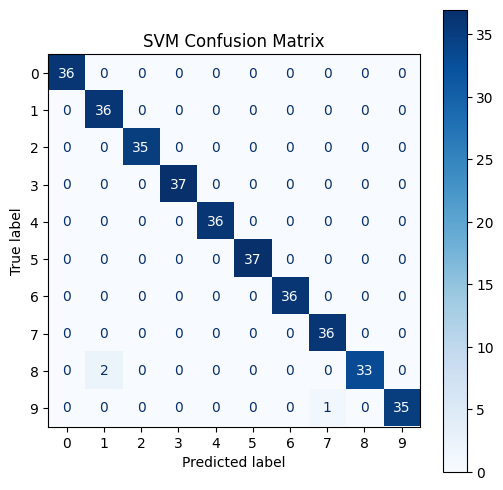

In [6]:
start_time = time.time()
# Instantiate and train Support Vector Machine
svm_model = SVC(max_iter=1000)
svm_model.fit(X_train_lr, y_train_lr)

# Evaluate on the test set
y_pred_lr = svm_model.predict(X_test_lr)
accuracy = (y_pred_lr == y_test_lr).mean()
print(f"Time taken: {time.time() - start_time:.4f} seconds")
print(f'SVM test accuracy: {accuracy:.4f}')



# Classification report
print(classification_report(y_test_lr, y_pred_lr))

# Confusion matrix
cm = confusion_matrix(y_test_lr, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()


Implementing a Support Vector Machine classifier using the default settings and the same data set with the same training and test split results in noticably better results compared to the Logistic Regression classifier. The logistic regression classifier was able to achieve an accuracy of 0.9583 while the suport vector machine classifier achieved and accuracy of 0.9917. It made mistakes in similar places, with both confusing 8's for 1's. 

For this accuracy, it appears like the SVM took more time to train and predict: 0.0276 seconds compared to the 0.0175 seconds for Logistic Regression.

# Part 1.2

Logistic regression test accuracy: 0.9583
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.89      0.86      0.87        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       0.92      1.00      0.96        36
           5       0.97      1.00      0.99        37
           6       0.97      0.94      0.96        36
           7       0.97      1.00      0.99        36
           8       0.91      0.89      0.90        35
           9       0.97      0.92      0.94        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



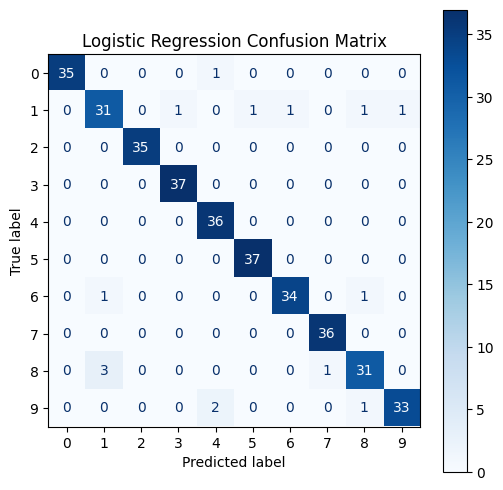

In [7]:
# L2
# Instantiate and train logistic regression
lr_model = LogisticRegression(solver = 'saga', random_state=17, penalty='l2', max_iter=1000)
lr_model.fit(X_train_lr, y_train_lr)

# Evaluate on the test set
y_pred_lr = lr_model.predict(X_test_lr)
accuracy = (y_pred_lr == y_test_lr).mean()
print(f'Logistic regression test accuracy: {accuracy:.4f}')

# Classification report
print(classification_report(y_test_lr, y_pred_lr))

# Confusion matrix
cm = confusion_matrix(y_test_lr, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

Logistic regression test accuracy: 0.9583
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        36
           1       0.91      0.83      0.87        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       0.95      1.00      0.97        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       0.95      1.00      0.97        36
           8       0.88      0.86      0.87        35
           9       0.97      0.92      0.94        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



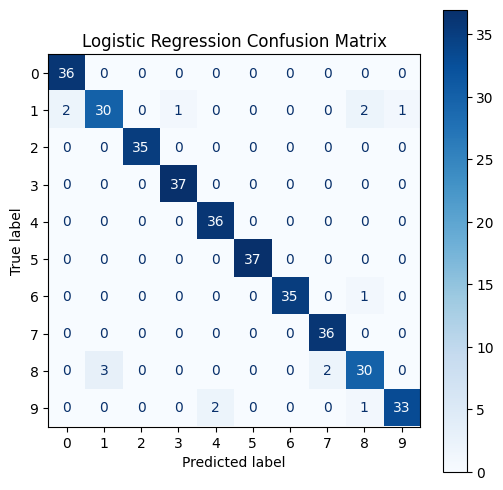

In [8]:
# L1
# Instantiate and train logistic regression
lr_model = LogisticRegression(solver='saga', random_state=17, penalty='l1', max_iter=1000)
lr_model.fit(X_train_lr, y_train_lr)

# Evaluate on the test set
y_pred_lr = lr_model.predict(X_test_lr)
accuracy = (y_pred_lr == y_test_lr).mean()
print(f'Logistic regression test accuracy: {accuracy:.4f}')

# Classification report
print(classification_report(y_test_lr, y_pred_lr))

# Confusion matrix
cm = confusion_matrix(y_test_lr, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

C		TrainAcc	CV Acc (mean ± std)
 0.0010	0.8692		0.8559 ± 0.0143
 0.0056	0.9071		0.8954 ± 0.0058
 0.0316	0.9416		0.9321 ± 0.0072
 0.1778	0.9672		0.9527 ± 0.0072
 1.0000	0.9850		0.9700 ± 0.0077
 5.6234	0.9978		0.9716 ± 0.0059
31.6228	0.9994		0.9677 ± 0.0038
177.8279	1.0000		0.9661 ± 0.0048
1000.0000	1.0000		0.9649 ± 0.0042

Best C by CV mean: 5.6234 (CV=0.9716 ± 0.0059)


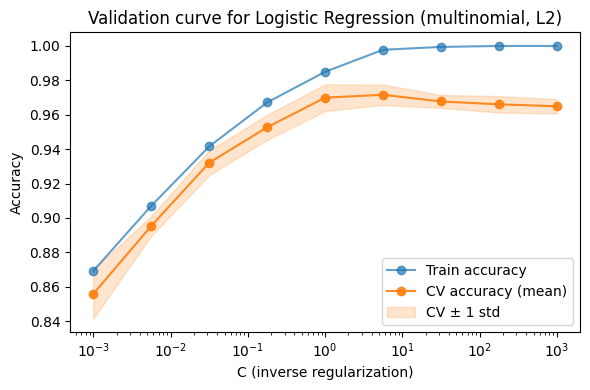

In [9]:
# Code in this cell mostly generated by GPT-5 (low reasoning) in Windsurf on 2025-09-02
# Generated by prompt: "Can you generate a cell for CV and validation curve over C"

# Cross-validation and validation curve over C for Logistic Regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

# Log-spaced C values (inverse regularization strength)
Cs = np.logspace(-3, 3, 9)

# 5-fold stratified CV (preserves class balance)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

val_means, val_stds, train_scores = [], [], []

for C in Cs:
    clf = LogisticRegression(
        C=C,
        penalty='l2',
        max_iter=2000,
        solver='saga',
        n_jobs=-1
    )
    # Cross-validated accuracy (generalization estimate)
    val = cross_val_score(clf, X_lr, y, cv=cv, scoring='accuracy', n_jobs=-1)
    val_means.append(val.mean())
    val_stds.append(val.std())

    # Approximate train accuracy by fitting on full data (diagnose overfitting trend)
    clf.fit(X_lr, y)
    train_scores.append(clf.score(X_lr, y))

# Print a compact table
print("C\t\tTrainAcc\tCV Acc (mean ± std)")
for C, tr, m, s in zip(Cs, train_scores, val_means, val_stds):
    print(f"{C:>7.4f}\t{tr:.4f}\t\t{m:.4f} ± {s:.4f}")

best_idx = int(np.argmax(val_means))
print(f"\nBest C by CV mean: {Cs[best_idx]:.4f} (CV={val_means[best_idx]:.4f} ± {val_stds[best_idx]:.4f})")

# Plot validation curve (and train for context)
plt.figure(figsize=(6,4))
plt.semilogx(Cs, train_scores, marker='o', label='Train accuracy', alpha=0.7)
plt.semilogx(Cs, val_means, marker='o', label='CV accuracy (mean)', alpha=0.9)
plt.fill_between(Cs, np.array(val_means)-np.array(val_stds), np.array(val_means)+np.array(val_stds),
                 color='C1', alpha=0.2, label='CV ± 1 std')
plt.xlabel('C (inverse regularization)')
plt.ylabel('Accuracy')
plt.title('Validation curve for Logistic Regression (multinomial, L2)')
plt.legend()
plt.tight_layout()
plt.show()

/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-Gen

C		TrainAcc	CV Acc (mean ± std)
 0.0010	0.1002		0.1018 ± 0.0013
 0.0056	0.1018		0.1007 ± 0.0021
 0.0316	0.8598		0.8208 ± 0.0203
 0.1778	0.9566		0.9343 ± 0.0089
 1.0000	0.9827		0.9655 ± 0.0067
 5.6234	0.9983		0.9672 ± 0.0057
31.6228	1.0000		0.9644 ± 0.0057
177.8279	1.0000		0.9649 ± 0.0054
1000.0000	1.0000		0.9644 ± 0.0054

Best C by CV mean: 5.6234 (CV=0.9672 ± 0.0057)


/Users/rkutyna/CascadeProjects/MSIT3103/MSIT3103-GenAI-assignments/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


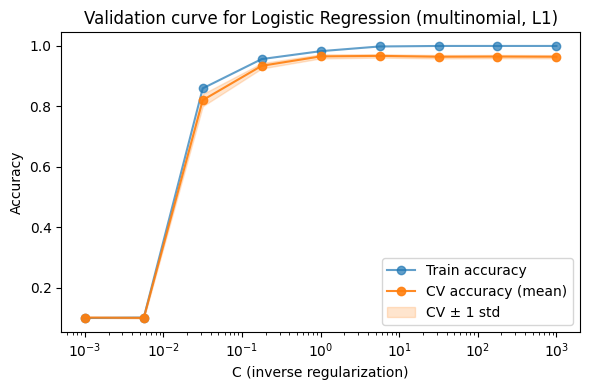

In [10]:
# Code in this cell mostly generated by GPT-5 (low reasoning) in Windsurf on 2025-09-02
# Generated by prompt: "Can you generate a cell for CV and validation curve over C"

# Cross-validation and validation curve over C for Logistic Regression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression

# Log-spaced C values (inverse regularization strength)
Cs = np.logspace(-3, 3, 9)

# 5-fold stratified CV (preserves class balance)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

val_means, val_stds, train_scores = [], [], []

for C in Cs:
    clf = LogisticRegression(
        C=C,
        penalty='l1',
        max_iter=2000,
        solver='saga',
        n_jobs=-1
    )
    # Cross-validated accuracy (generalization estimate)
    val = cross_val_score(clf, X_lr, y, cv=cv, scoring='accuracy', n_jobs=-1)
    val_means.append(val.mean())
    val_stds.append(val.std())

    # Approximate train accuracy by fitting on full data (diagnose overfitting trend)
    clf.fit(X_lr, y)
    train_scores.append(clf.score(X_lr, y))

# Print a compact table
print("C\t\tTrainAcc\tCV Acc (mean ± std)")
for C, tr, m, s in zip(Cs, train_scores, val_means, val_stds):
    print(f"{C:>7.4f}\t{tr:.4f}\t\t{m:.4f} ± {s:.4f}")

best_idx = int(np.argmax(val_means))
print(f"\nBest C by CV mean: {Cs[best_idx]:.4f} (CV={val_means[best_idx]:.4f} ± {val_stds[best_idx]:.4f})")

# Plot validation curve (and train for context)
plt.figure(figsize=(6,4))
plt.semilogx(Cs, train_scores, marker='o', label='Train accuracy', alpha=0.7)
plt.semilogx(Cs, val_means, marker='o', label='CV accuracy (mean)', alpha=0.9)
plt.fill_between(Cs, np.array(val_means)-np.array(val_stds), np.array(val_means)+np.array(val_stds),
                 color='C1', alpha=0.2, label='CV ± 1 std')
plt.xlabel('C (inverse regularization)')
plt.ylabel('Accuracy')
plt.title('Validation curve for Logistic Regression (multinomial, L1)')
plt.legend()
plt.tight_layout()
plt.show()

L2 generalizes better at optimal c, l1 has more robustness to hyperparameter choice as it performed more similarly accross a range of c values.
L1 Also overfits slightly earlier than L2.

# Part 1.3

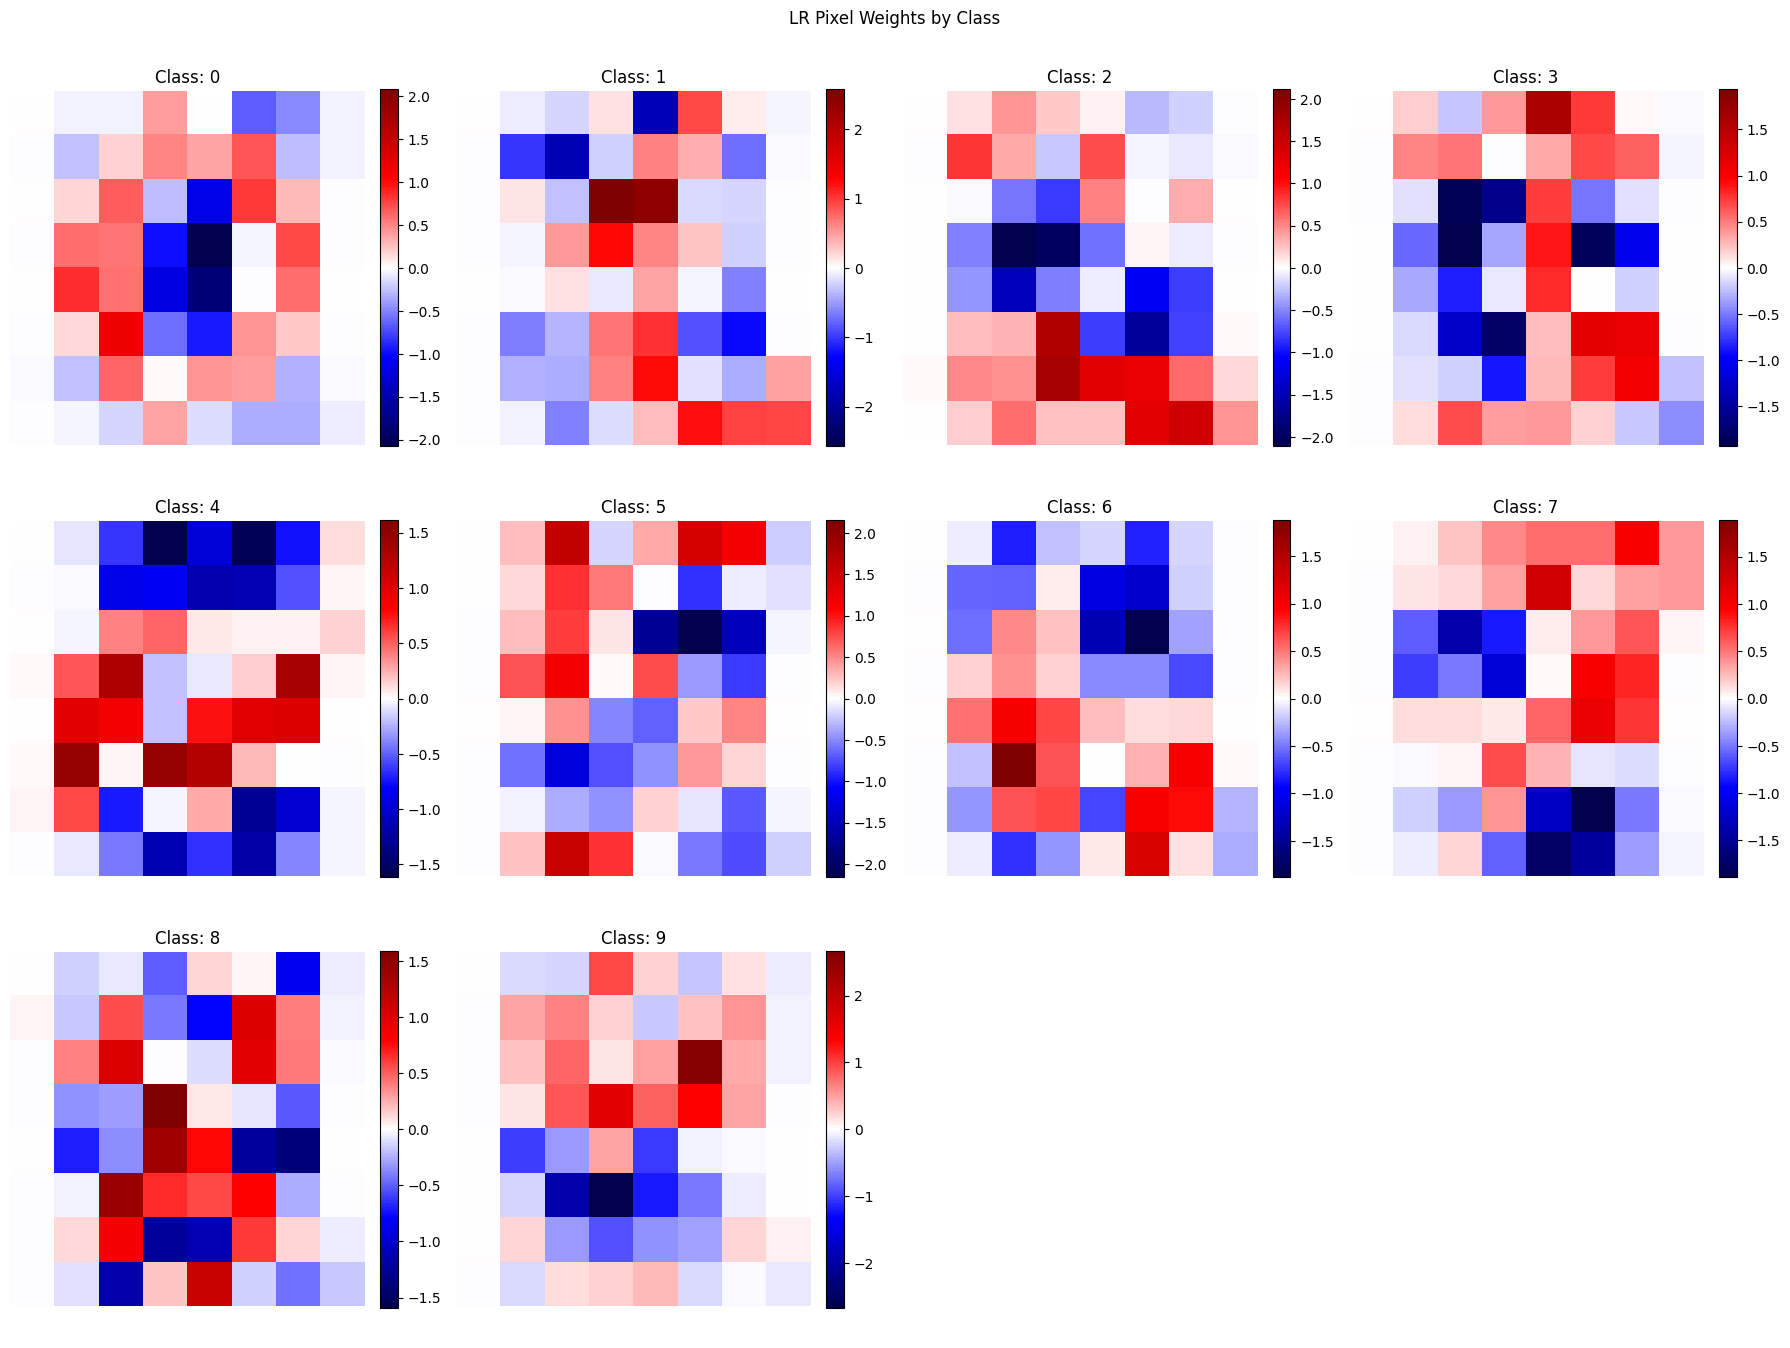

In [11]:
# Instantiate and train logistic regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_lr, y_train_lr)

# Evaluate on the test set
y_pred_lr = lr_model.predict(X_test_lr)
accuracy = (y_pred_lr == y_test_lr).mean()


# Code in this cell mostly generated by GPT-5 (low reasoning) in Windsurf on 2025-09-02
# Generated by prompt: "How can I get the weights for each label from an sklearn logistic 
# regression model? I would like to get them and create a heat map to show which pixels are 
# most influential for each class"


# Plots per-pixel weights for each class in the logistic regression
def plot_lr_pixel_weights(model, image_shape, class_names=None, vabs=None, cmap='seismic',
                          layout=None, cell_size=4.0, suptitle=None):
    """
    layout: list of ints specifying number of plots per row, e.g., [3,3,3,2] for 10 classes.
            If None, uses rows of up to 3 per row.
    cell_size: inches per subplot cell (controls how big each heat map appears).
    """
    # Extract LR and optional scaler if inside a Pipeline
    lr = model
    scaler = None
    try:
        from sklearn.pipeline import Pipeline
        if isinstance(model, Pipeline):
            lr = model.named_steps.get('logisticregression', lr)
            scaler = model.named_steps.get('standardscaler', None)
    except Exception:
        pass

    coef = lr.coef_.copy()

    # Undo StandardScaler so weights are in original pixel units
    if scaler is not None and hasattr(scaler, "scale_"):
        coef = coef / scaler.scale_

    H, W = image_shape[:2]
    n_classes = coef.shape[0]
    classes = getattr(lr, 'classes_', np.arange(n_classes))
    if class_names is None:
        class_names = [str(c) for c in classes]

    # Build layout
    if layout is None:
        # Default: rows of up to 3
        full_rows, rem = divmod(n_classes, 3)
        layout = [3]*full_rows + ([rem] if rem else [])
        layout = [r for r in layout if r > 0]
    else:
        if sum(layout) < n_classes:
            raise ValueError("layout has fewer slots than classes.")
    rows = len(layout)
    cols = max(layout) if layout else 1

    fig, axes = plt.subplots(rows, cols, figsize=(cols*cell_size, rows*cell_size), squeeze=False)

    idx = 0
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            if c < layout[r] and idx < n_classes:
                w = coef[idx].reshape(H, W)
                vmax = vabs if vabs is not None else np.abs(w).max()
                im = ax.imshow(w, cmap=cmap, vmin=-vmax, vmax=vmax)
                ax.set_title(f'Class: {class_names[idx]}')
                ax.axis('off')
                # small colorbar per axis to aid interpretation
                fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                idx += 1
            else:
                ax.axis('off')

    if suptitle:
        fig.suptitle(suptitle, y=0.995)

    plt.tight_layout()
    plt.show()


# Bigger charts in a 4-row layout: 3,3,3,2
plot_lr_pixel_weights(
    lr_model,
    image_shape=(8, 8),
    layout=[4,4,2],
    cell_size=4.5,          # increase to make each heat map larger
    suptitle='LR Pixel Weights by Class'
)

It seems to me that within these heat maps, the pixes with high weights are those that strongly correlate with the shape of the numbers, specificially, the parts of the numbers that are unique to that number. For example, the seven has high weights in the top right corner, which no other numbers have. The lowest weights in the heap map seem to correspond to the pixes that have high weights in other numbers and are not represented in the pixes of the number. For example, six has low weight pixels in the top right, this is likely to differentiate it from the eight which is similar in shape, besides in the top right pixels.

# Part 1.4

Based on the earlier testing with varing CV testing accross a range of C's, the logistic regression is pretty robust accross a range of C from 1-1000 for penalties L1 and L2. Below 1, the accuracy of the model breaks down, dropping below the ~96% that 1+ gives. The standard deviation also remains consistent at C values from 1+, remaining around 0.005-0.007.

# Part 2.5

In [12]:
# Code generated by GPT-5 (medium reasoning) via Windsurf on 9/3.25
# Prompt: "(Context given: Cell containing simple GAN that was given earlier in this assignment) 
# Can you turn this into a function that takes in the "parameters for the simple GAN" as parameters? 
# I would like to be able to call it in later cells without having to redefine it each time"

# Prompt 2: "Can you make it so that it will generate sample images every 500 iterations? C
# an you also make this controllable by a boolean parameter?"

def train_simple_gan(
    X_gan,
    noise_dim=20,
    hidden_dim_g=64,
    hidden_dim_d=64,
    batch_size=64,
    learning_rate_d=5e-4,
    learning_rate_g=5e-4,
    num_steps=1500,
    seed=42,
    verbose_every=500,
    generate_n=16,
    plot=True,
    show_intermediate_samples=True,
    sample_interval=500,
):
    rng = np.random.default_rng(seed)

    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    input_dim = X_gan.shape[1]
    side = int(np.sqrt(input_dim))  # for display if square

    # Initialise weights for generator and discriminator
    # Generator weights
    W1_g = rng.normal(0, 0.1, size=(noise_dim, hidden_dim_g))
    b1_g = np.zeros(hidden_dim_g)
    W2_g = rng.normal(0, 0.1, size=(hidden_dim_g, input_dim))
    b2_g = np.zeros(input_dim)
    # Discriminator weights
    W1_d = rng.normal(0, 0.1, size=(input_dim, hidden_dim_d))
    b1_d = np.zeros(hidden_dim_d)
    W2_d = rng.normal(0, 0.1, size=(hidden_dim_d, 1))
    b2_d = np.zeros(1)

    # Lists to record losses
    losses_d = []
    losses_g = []
    intermediate_samples = []  # collect snapshots if desired

    # Training loop
    for step in range(num_steps):
        # Sample a minibatch of real images
        replace_flag = False if len(X_gan) >= batch_size else True
        idx = rng.choice(len(X_gan), size=batch_size, replace=replace_flag)
        real_batch = X_gan[idx]

        # Sample random noise
        z = rng.normal(0, 1, size=(batch_size, noise_dim))

        # -------- Generator forward pass --------
        g_h_pre = z @ W1_g + b1_g
        g_h = np.maximum(0, g_h_pre)
        g_pre = g_h @ W2_g + b2_g
        fake_batch = np.tanh(g_pre)

        # -------- Discriminator forward pass on real images --------
        d_h_pre_real = real_batch @ W1_d + b1_d
        d_h_real = np.maximum(0, d_h_pre_real)
        d_logits_real = d_h_real @ W2_d + b2_d
        d_out_real = sigmoid(d_logits_real)

        # -------- Discriminator forward pass on fake images --------
        d_h_pre_fake = fake_batch @ W1_d + b1_d
        d_h_fake = np.maximum(0, d_h_pre_fake)
        d_logits_fake = d_h_fake @ W2_d + b2_d
        d_out_fake = sigmoid(d_logits_fake)

        # -------- Discriminator loss and gradients --------
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        loss_d = -(np.mean(np.log(d_out_real + 1e-8)) + np.mean(np.log(1 - d_out_fake + 1e-8)))

        d_delta_real = (d_out_real - y_real) / batch_size
        d_delta_fake = (d_out_fake - y_fake) / batch_size

        grad_W2_d = d_h_real.T @ d_delta_real + d_h_fake.T @ d_delta_fake
        grad_b2_d = np.sum(d_delta_real + d_delta_fake, axis=0)

        d_grad_h_real = d_delta_real @ W2_d.T
        d_grad_h_real[d_h_pre_real <= 0] = 0
        d_grad_h_fake = d_delta_fake @ W2_d.T
        d_grad_h_fake[d_h_pre_fake <= 0] = 0

        grad_W1_d = real_batch.T @ d_grad_h_real + fake_batch.T @ d_grad_h_fake
        grad_b1_d = np.sum(d_grad_h_real + d_grad_h_fake, axis=0)

        # Update discriminator parameters
        W2_d -= learning_rate_d * grad_W2_d
        b2_d -= learning_rate_d * grad_b2_d
        W1_d -= learning_rate_d * grad_W1_d
        b1_d -= learning_rate_d * grad_b1_d

        # -------- Generator loss and gradients --------
        y_gen = np.ones((batch_size, 1))
        loss_g = -np.mean(np.log(d_out_fake + 1e-8))

        g_delta_d = (d_out_fake - y_gen) / batch_size
        g_grad_h_fake = g_delta_d @ W2_d.T
        g_grad_h_fake[d_h_pre_fake <= 0] = 0
        grad_fake_input = g_grad_h_fake @ W1_d.T
        grad_g_pre = grad_fake_input * (1 - fake_batch ** 2)

        grad_W2_g = g_h.T @ grad_g_pre
        grad_b2_g = np.sum(grad_g_pre, axis=0)
        g_grad_h = grad_g_pre @ W2_g.T
        g_grad_h[g_h_pre <= 0] = 0
        grad_W1_g = z.T @ g_grad_h
        grad_b1_g = np.sum(g_grad_h, axis=0)

        # Update generator parameters
        W2_g -= learning_rate_g * grad_W2_g
        b2_g -= learning_rate_g * grad_b2_g
        W1_g -= learning_rate_g * grad_W1_g
        b1_g -= learning_rate_g * grad_b1_g

        # Record losses
        losses_d.append(loss_d)
        losses_g.append(loss_g)

        # if verbose_every and (step + 1) % verbose_every == 0:
        #     print(f"Step {step+1}/{num_steps}, loss_D={loss_d:.4f}, loss_G={loss_g:.4f}")

        # Periodic sample visualization
        if (
            plot
            and show_intermediate_samples
            and sample_interval
            and (step + 1) % sample_interval == 0
            and side * side == input_dim  # only if images are square
        ):
            z_sample_step = rng.normal(0, 1, size=(generate_n, noise_dim))
            g_h_pre_s = z_sample_step @ W1_g + b1_g
            g_h_s = np.maximum(0, g_h_pre_s)
            g_pre_s = g_h_s @ W2_g + b2_g
            fake_samples_step = np.tanh(g_pre_s)
            intermediate_samples.append(fake_samples_step)

            nrows = ncols = int(np.ceil(np.sqrt(generate_n)))
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
            axes = np.array(axes).reshape(nrows, ncols)
            for i, ax in enumerate(axes.flat):
                ax.axis('off')
                if i < generate_n:
                    ax.imshow(fake_samples_step[i].reshape(side, side), cmap='gray')
            plt.suptitle(f'Samples at step {step+1}')
            plt.tight_layout()
            plt.show()

    # After training, generate a batch of images for visualisation
    z_sample = rng.normal(0, 1, size=(generate_n, noise_dim))
    g_h_pre = z_sample @ W1_g + b1_g
    g_h = np.maximum(0, g_h_pre)
    g_pre = g_h @ W2_g + b2_g
    fake_samples = np.tanh(g_pre)

    if plot:
        # Loss curves
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(losses_d, label='Discriminator loss')
        ax.plot(losses_g, label='Generator loss')
        ax.set_xlabel('Training step')
        ax.set_ylabel('Loss')
        ax.set_title('GAN Training Losses')
        ax.legend()
        plt.show()

        # Final samples
        if side * side == input_dim:
            nrows = ncols = int(np.ceil(np.sqrt(generate_n)))
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
            axes = np.array(axes).reshape(nrows, ncols)
            for i, ax in enumerate(axes.flat):
                ax.axis('off')
                if i < generate_n:
                    ax.imshow(fake_samples[i].reshape(side, side), cmap='gray')
            plt.suptitle('Samples generated by the simple GAN after training')
            plt.tight_layout()
            plt.show()

    return {
        "fake_samples": fake_samples,
        "losses_d": losses_d,
        "losses_g": losses_g,
        "intermediate_samples": intermediate_samples,
        "weights": {
            "W1_g": W1_g, "b1_g": b1_g, "W2_g": W2_g, "b2_g": b2_g,
            "W1_d": W1_d, "b1_d": b1_d, "W2_d": W2_d, "b2_d": b2_d,
        },
        "rng": rng,
        "params": {
            "noise_dim": noise_dim,
            "hidden_dim_g": hidden_dim_g,
            "hidden_dim_d": hidden_dim_d,
            "batch_size": batch_size,
            "learning_rate_d": learning_rate_d,
            "learning_rate_g": learning_rate_g,
            "num_steps": num_steps,
            "sample_interval": sample_interval,
            "show_intermediate_samples": show_intermediate_samples,
        },
    }

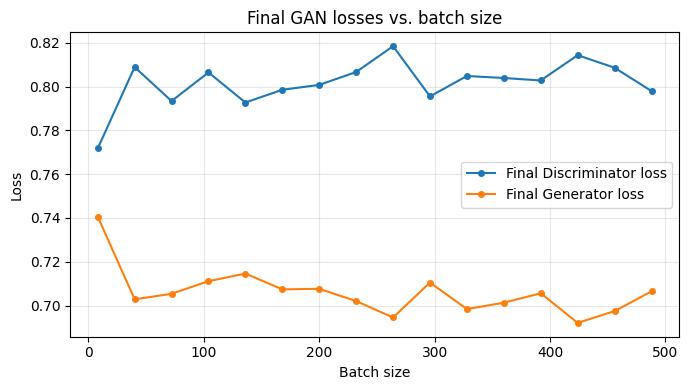

In [13]:
result=[]
for i in range(8, 512, 32):
    #print("Batch Size:", i)
    result.append(train_simple_gan(
        X_gan,
        noise_dim=20,
        hidden_dim_g=64,
        hidden_dim_d=64,
        batch_size=i,
        learning_rate_d=0.0005,
        learning_rate_g=0.0005,
        num_steps=1500,
        seed=42,
        generate_n=16,
        plot=False,
        show_intermediate_samples=False,
        sample_interval=500,
    ))

# Generated by GPT 5 (medium reasoning) via Windsurf on 9/2/25
# Prompt: "Can you write a matplotlib figure to plot the final 
# loss d and loss g over batch size? Please make it so that it 
# extracts these out of the result list that the code I have given 
# you will create" + the above for loop as context.

# Extract (batch_size, final_loss_d, final_loss_g)
data = []
for r in result:
    bs = r["params"]["batch_size"]
    ld = r["losses_d"][-1]
    lg = r["losses_g"][-1]
    data.append((bs, ld, lg))

# Sort by batch size to ensure monotonic x-axis
data.sort(key=lambda x: x[0])

batch_sizes = np.array([d[0] for d in data])
final_loss_d = np.array([d[1] for d in data])
final_loss_g = np.array([d[2] for d in data])

plt.figure(figsize=(7, 4))
plt.plot(batch_sizes, final_loss_d, "-o", ms=4, label="Final Discriminator loss")
plt.plot(batch_sizes, final_loss_g, "-o", ms=4, label="Final Generator loss")
plt.xlabel("Batch size")
plt.ylabel("Loss")
plt.title("Final GAN losses vs. batch size")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

As can be seen in the above chart, the batch size seems to primarily determine the variance within the loss. As the batch size goes up, the loss becomes generally more consistent. At a small batch size, the loss seems to oscilate much more, which implies that the models are being trained on a sample size that is too small and not representative. When looking at the generated samples, they pretty much look like noise unfortunately.

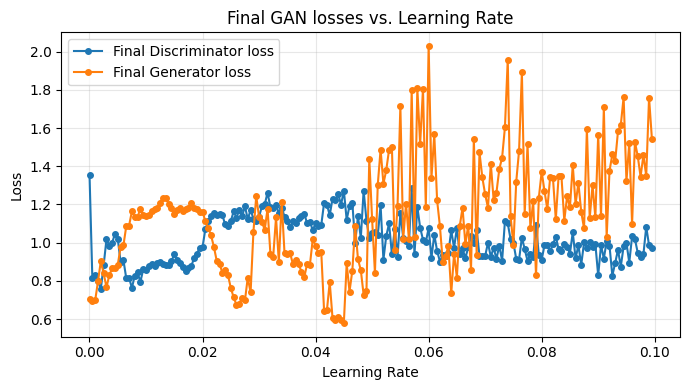

In [14]:
result=[]
for i in range(1, 10000, 50):
    #print("Learning Rate :", i/100000)
    result.append(train_simple_gan(
        X_gan,
        noise_dim=20,
        hidden_dim_g=64,
        hidden_dim_d=64,
        batch_size=64,
        learning_rate_d=i/100000,
        learning_rate_g=i/100000,
        num_steps=1500,
        seed=42,
        generate_n=16,
        plot=False,
        show_intermediate_samples=False,
        sample_interval=500,
    ))

# Generated by GPT 5 (medium reasoning) via Windsurf on 9/2/25
# Prompt: "Can you write a matplotlib figure to plot the final 
# loss d and loss g over batch size? Please make it so that it 
# extracts these out of the result list that the code I have given 
# you will create" + the above for loop as context.

# Extract (batch_size, final_loss_d, final_loss_g)
data = []
for r in result:
    bs = r["params"]["learning_rate_d"]
    ld = r["losses_d"][-1]
    lg = r["losses_g"][-1]
    data.append((bs, ld, lg))

# Sort by batch size to ensure monotonic x-axis
data.sort(key=lambda x: x[0])

learning_rate = np.array([d[0] for d in data])
final_loss_d = np.array([d[1] for d in data])
final_loss_g = np.array([d[2] for d in data])

plt.figure(figsize=(7, 4))
plt.plot(learning_rate, final_loss_d, "-o", ms=4, label="Final Discriminator loss")
plt.plot(learning_rate, final_loss_g, "-o", ms=4, label="Final Generator loss")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Final GAN losses vs. Learning Rate")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

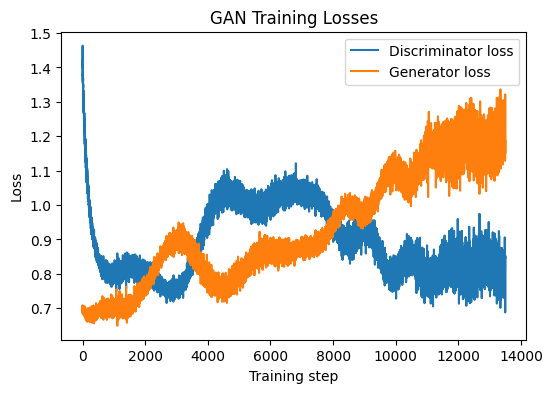

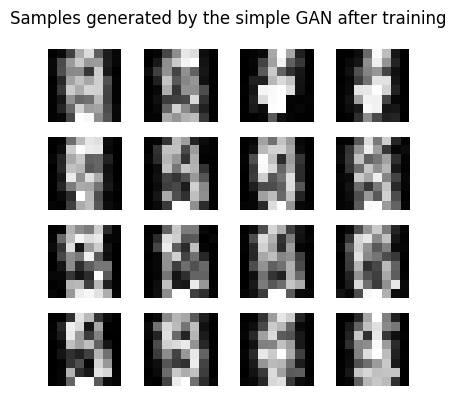

In [15]:
result = train_simple_gan(
        X_gan,
        noise_dim=20,
        hidden_dim_g=64,
        hidden_dim_d=64,
        batch_size=64,
        learning_rate_d=0.00101,
        learning_rate_g=0.00101,
        num_steps=13500,
        seed=42,
        generate_n=16,
        plot=True,
        show_intermediate_samples=False,
        sample_interval=500,
    )


This is incredibly interesting. It appears to me, that when increaseing the learning rate, at lease to a certain degree, it doesn't fundamentally change model performance, but instead essentially just multiplies the rate of training for the given number of training steps. So by increasing the learning rate, you are essentially just doing more training steps. This even increases at a linear rate. For example, The result for a learning rate of 0.00901 with 1500 training steps produces almost the exact loss over training steps graph as using a learning rate of 0.001 that has 13,500 training steps, which is 900 * 1500.
This is not shown because it takes up a large amount of space in the notebook, but you can also see that the scaling of loss over learning rate with constant training steps takes the same shape as well.

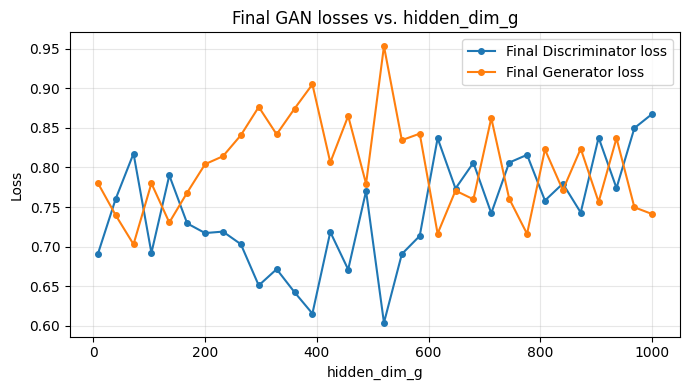

In [16]:
# Examine the impact of varying the number of hidden neurons for the generator

result=[]
for i in range(8, 1024, 32):
    #print("hidden_dim_g:", i)
    result.append(train_simple_gan(
        X_gan,
        noise_dim=20,
        hidden_dim_g=i,
        hidden_dim_d=64,
        batch_size=64,
        learning_rate_d=0.0005,
        learning_rate_g=0.0005,
        num_steps=1500,
        seed=42,
        generate_n=16,
        plot=False,
        show_intermediate_samples=False,
        sample_interval=500,
    ))

# Generated by GPT 5 (medium reasoning) via Windsurf on 9/2/25
# Prompt: "Can you write a matplotlib figure to plot the final 
# loss d and loss g over batch size? Please make it so that it 
# extracts these out of the result list that the code I have given 
# you will create" + the above for loop as context.

# Extract (hidden_dim_g, final_loss_d, final_loss_g)
data = []
for r in result:
    bs = r["params"]["hidden_dim_g"]
    ld = r["losses_d"][-1]
    lg = r["losses_g"][-1]
    data.append((bs, ld, lg))

# Sort by hidden_dim_g to ensure monotonic x-axis
data.sort(key=lambda x: x[0])

batch_sizes = np.array([d[0] for d in data])
final_loss_d = np.array([d[1] for d in data])
final_loss_g = np.array([d[2] for d in data])

plt.figure(figsize=(7, 4))
plt.plot(batch_sizes, final_loss_d, "-o", ms=4, label="Final Discriminator loss")
plt.plot(batch_sizes, final_loss_g, "-o", ms=4, label="Final Generator loss")
plt.xlabel("hidden_dim_g")
plt.ylabel("Loss")
plt.title("Final GAN losses vs. hidden_dim_g")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

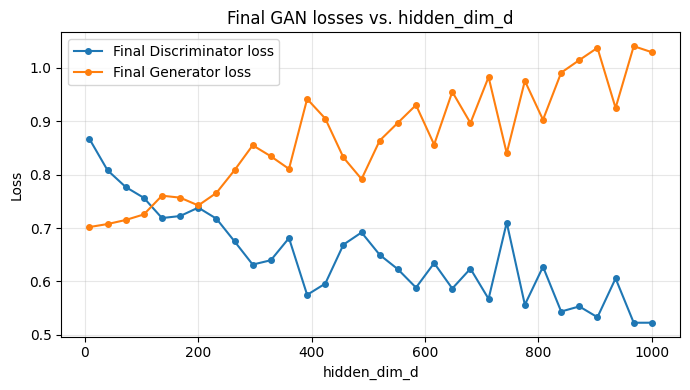

In [17]:
# Examine the impact of varying the number of hidden neurons 
# for the discriminator

result=[]
for i in range(8, 1024, 32):
    #print("hidden_dim_g:", i)
    result.append(train_simple_gan(
        X_gan,
        noise_dim=20,
        hidden_dim_g=64,
        hidden_dim_d=i,
        batch_size=64,
        learning_rate_d=0.0005,
        learning_rate_g=0.0005,
        num_steps=1500,
        seed=42,
        generate_n=16,
        plot=False,
        show_intermediate_samples=False,
        sample_interval=500,
    ))

# Generated by GPT 5 (medium reasoning) via Windsurf on 9/2/25
# Prompt: "Can you write a matplotlib figure to plot the final 
# loss d and loss g over batch size? Please make it so that it 
# extracts these out of the result list that the code I have given 
# you will create" + the above for loop as context.

# Extract (hidden_dim_g, final_loss_d, final_loss_g)
data = []
for r in result:
    bs = r["params"]["hidden_dim_d"]
    ld = r["losses_d"][-1]
    lg = r["losses_g"][-1]
    data.append((bs, ld, lg))

# Sort by hidden_dim_g to ensure monotonic x-axis
data.sort(key=lambda x: x[0])

batch_sizes = np.array([d[0] for d in data])
final_loss_d = np.array([d[1] for d in data])
final_loss_g = np.array([d[2] for d in data])

plt.figure(figsize=(7, 4))
plt.plot(batch_sizes, final_loss_d, "-o", ms=4, label="Final Discriminator loss")
plt.plot(batch_sizes, final_loss_g, "-o", ms=4, label="Final Generator loss")
plt.xlabel("hidden_dim_d")
plt.ylabel("Loss")
plt.title("Final GAN losses vs. hidden_dim_d")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

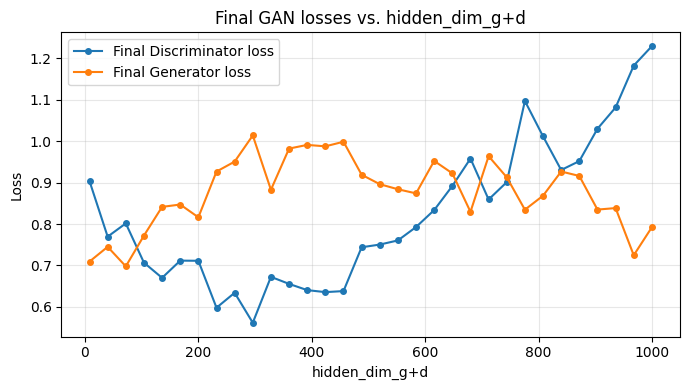

In [18]:
# Examine the impact of varying the number of hidden 
# neurons for the generator and discriminator at the same time

result=[]
for i in range(8, 1024, 32):
    #print("hidden_dim_g:", i)
    result.append(train_simple_gan(
        X_gan,
        noise_dim=20,
        hidden_dim_g=i,
        hidden_dim_d=i,
        batch_size=64,
        learning_rate_d=0.0005,
        learning_rate_g=0.0005,
        num_steps=1500,
        seed=42,
        generate_n=16,
        plot=False,
        show_intermediate_samples=False,
        sample_interval=500,
    ))

# Generated by GPT 5 (medium reasoning) via Windsurf on 9/2/25
# Prompt: "Can you write a matplotlib figure to plot the final 
# loss d and loss g over batch size? Please make it so that it 
# extracts these out of the result list that the code I have given 
# you will create" + the above for loop as context.

# Extract (hidden_dim_g, final_loss_d, final_loss_g)
data = []
for r in result:
    bs = r["params"]["hidden_dim_d"]
    ld = r["losses_d"][-1]
    lg = r["losses_g"][-1]
    data.append((bs, ld, lg))

# Sort by hidden_dim_g to ensure monotonic x-axis
data.sort(key=lambda x: x[0])

batch_sizes = np.array([d[0] for d in data])
final_loss_d = np.array([d[1] for d in data])
final_loss_g = np.array([d[2] for d in data])

plt.figure(figsize=(7, 4))
plt.plot(batch_sizes, final_loss_d, "-o", ms=4, label="Final Discriminator loss")
plt.plot(batch_sizes, final_loss_g, "-o", ms=4, label="Final Generator loss")
plt.xlabel("hidden_dim_g+d")
plt.ylabel("Loss")
plt.title("Final GAN losses vs. hidden_dim_g+d")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

It appears to me that increasing the number of hidden neurons for the generator works to make it perform better than the discriminator in the 200-600 neuron area, but then the losses become much more even below and above that area. Unfortunately, the sample images still look like noise. When increasing the number of hidden neurons for the discriminator, but not the generator, the discriminator starts to perform much better, above about 200 neurons. However, the resulting images look like noise. 
When increasing the number of hidden neurons for both, the discriminator has an advantage for loss from ~100-~600, then it becomes pretty even, before the generator gains and advantage around ~850 neurons. However, contrary to the two previous examples, the images produced look much better and less like noise. 

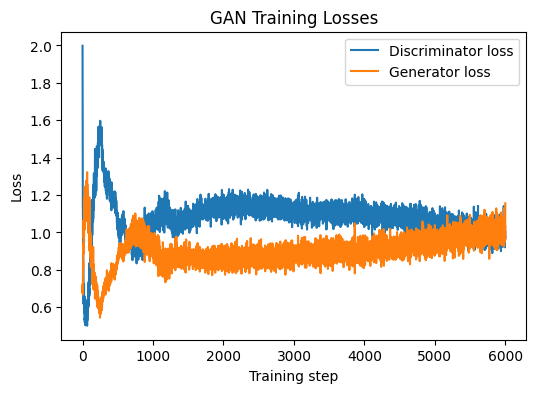

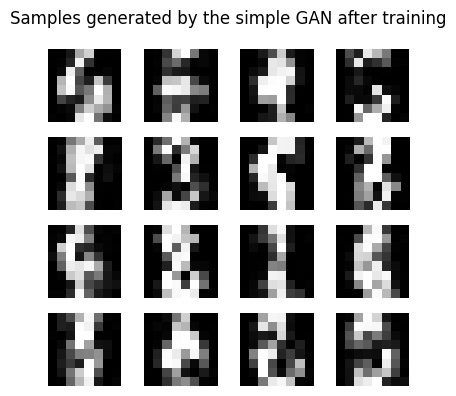

In [19]:
# This seems like about the best result that I could achieve with the time that
# I have spent so far. The numbers are entirely plausible looking numbers and
# defined shapes and colors, with minimal noise. 

result=train_simple_gan(
        X_gan,
        noise_dim=20,
        hidden_dim_g=800,
        hidden_dim_d=800,
        batch_size=64,
        learning_rate_d=0.005,
        learning_rate_g=0.005,
        num_steps=6000,
        seed=42,
        generate_n=16,
        plot=True,
        show_intermediate_samples=False,
        sample_interval=300,)

In [20]:
# Generated by GPT-5 (high reasoning) via windsurf on 9/3/25
# Prompt: "Can you generate a new version of this function such that the GAN has a new parameters 
# for the number of hidden layers that the generator and discriminator have?"
def train_simple_gan(
    X_gan,
    noise_dim=20,
    hidden_dim_g=64,
    hidden_dim_d=64,
    num_hidden_layers_g=1,
    num_hidden_layers_d=1,
    batch_size=64,
    learning_rate_d=5e-4,
    learning_rate_g=5e-4,
    num_steps=1500,
    seed=42,
    verbose_every=500,
    generate_n=16,
    plot=True,
    show_intermediate_samples=True,
    sample_interval=500,
):
    """
    Train a simple GAN with configurable numbers of hidden layers.

    - Generator: num_hidden_layers_g hidden layers (ReLU), final tanh to data dim.
    - Discriminator: num_hidden_layers_d hidden layers (ReLU), final sigmoid to 1.

    If num_hidden_layers_* == 0, the network is a single linear layer to the output activation.
    """
    rng = np.random.default_rng(seed)

    def sigmoid(x):
        return 1.0 / (1.0 + np.exp(-x))

    input_dim = X_gan.shape[1]
    side = int(np.sqrt(input_dim))  # for display if square

    # Build layer dimensions
    dims_g = [noise_dim] + [hidden_dim_g] * num_hidden_layers_g + [input_dim]
    dims_d = [input_dim] + [hidden_dim_d] * num_hidden_layers_d + [1]

    # Initialise weights
    W_g = [rng.normal(0, 0.1, size=(dims_g[i], dims_g[i + 1])) for i in range(len(dims_g) - 1)]
    b_g = [np.zeros(dims_g[i + 1]) for i in range(len(dims_g) - 1)]
    W_d = [rng.normal(0, 0.1, size=(dims_d[i], dims_d[i + 1])) for i in range(len(dims_d) - 1)]
    b_d = [np.zeros(dims_d[i + 1]) for i in range(len(dims_d) - 1)]

    # Helpers
    def forward_g(z):
        """
        Returns:
          fake: (batch, input_dim)
          pres: list of pre-activations per layer [L0, L1, ..., Lout]
          acts: list of activations including input and hidden only: [z, h1, ..., hL] (no output)
        """
        acts = [z]  # input then hidden activations appended
        pres = []
        a = z
        for i in range(len(W_g)):
            pre = a @ W_g[i] + b_g[i]
            pres.append(pre)
            if i < len(W_g) - 1:
                a = np.maximum(0, pre)  # ReLU hidden
                acts.append(a)
            else:
                a = np.tanh(pre)  # output
        fake = a
        return fake, pres, acts

    def forward_d(x):
        """
        Returns:
          logits: (batch, 1)
          out: sigmoid(logits)
          pres: list of pre-activations of hidden layers only
          acts: list of activations including input and hidden only: [x, h1, ..., hL]
        """
        acts = [x]
        pres = []
        a = x
        # hidden layers
        for i in range(len(W_d) - 1):
            pre = a @ W_d[i] + b_d[i]
            pres.append(pre)
            a = np.maximum(0, pre)
            acts.append(a)
        # output layer
        logits = a @ W_d[-1] + b_d[-1]
        out = sigmoid(logits)
        return logits, out, pres, acts

    # Training bookkeeping
    losses_d = []
    losses_g = []
    intermediate_samples = []

    # Training loop
    for step in range(num_steps):
        # Minibatch of real images
        replace_flag = False if len(X_gan) >= batch_size else True
        idx = rng.choice(len(X_gan), size=batch_size, replace=replace_flag)
        real_batch = X_gan[idx]

        # Noise
        z = rng.normal(0, 1, size=(batch_size, noise_dim))

        # Forward passes
        fake_batch, g_pres, g_acts = forward_g(z)
        d_logits_real, d_out_real, d_pres_real, d_acts_real = forward_d(real_batch)
        d_logits_fake, d_out_fake, d_pres_fake, d_acts_fake = forward_d(fake_batch)

        # -------- Discriminator loss and gradients --------
        y_real = np.ones((batch_size, 1))
        y_fake = np.zeros((batch_size, 1))
        loss_d = -(np.mean(np.log(d_out_real + 1e-8)) + np.mean(np.log(1 - d_out_fake + 1e-8)))

        dlogits_real = (d_out_real - y_real) / batch_size  # dL/d(logits_real)
        dlogits_fake = (d_out_fake - y_fake) / batch_size  # dL/d(logits_fake)

        grad_W_d = [np.zeros_like(W) for W in W_d]
        grad_b_d = [np.zeros_like(b) for b in b_d]

        # Output layer grads
        last_hidden_real = d_acts_real[-1]  # input if no hidden layers
        last_hidden_fake = d_acts_fake[-1]
        grad_W_d[-1] = last_hidden_real.T @ dlogits_real + last_hidden_fake.T @ dlogits_fake
        grad_b_d[-1] = np.sum(dlogits_real + dlogits_fake, axis=0)

        # Backprop into hidden
        d_hidden_real = dlogits_real @ W_d[-1].T
        d_hidden_fake = dlogits_fake @ W_d[-1].T

        for l in reversed(range(len(W_d) - 1)):
            d_pre_real = d_hidden_real * (d_pres_real[l] > 0)
            d_pre_fake = d_hidden_fake * (d_pres_fake[l] > 0)
            grad_W_d[l] = d_acts_real[l].T @ d_pre_real + d_acts_fake[l].T @ d_pre_fake
            grad_b_d[l] = np.sum(d_pre_real + d_pre_fake, axis=0)
            d_hidden_real = d_pre_real @ W_d[l].T
            d_hidden_fake = d_pre_fake @ W_d[l].T

        # Update D
        for i in range(len(W_d)):
            W_d[i] -= learning_rate_d * grad_W_d[i]
            b_d[i] -= learning_rate_d * grad_b_d[i]

        # -------- Generator loss and gradients --------
        y_gen = np.ones((batch_size, 1))
        loss_g = -np.mean(np.log(d_out_fake + 1e-8))

        # Backprop through (updated) D to its input (fake_batch)
        dlogits_fake_gen = (d_out_fake - y_gen) / batch_size  # dL/d(logits_fake) where target=1
        d_hidden = dlogits_fake_gen @ W_d[-1].T
        for l in reversed(range(len(W_d) - 1)):
            d_hidden = (d_hidden * (d_pres_fake[l] > 0)) @ W_d[l].T
        grad_input_D = d_hidden  # dL/dfake_batch

        # Backprop through G
        d_g_pre_out = grad_input_D * (1 - fake_batch**2)  # tanh' = 1 - tanh^2
        grad_W_g = [np.zeros_like(W) for W in W_g]
        grad_b_g = [np.zeros_like(b) for b in b_g]

        # Output layer grads (G)
        last_hidden_g = g_acts[-1]  # z if no hidden layers, else last hidden
        grad_W_g[-1] = last_hidden_g.T @ d_g_pre_out
        grad_b_g[-1] = np.sum(d_g_pre_out, axis=0)

        d_hidden_g = d_g_pre_out @ W_g[-1].T
        for l in reversed(range(len(W_g) - 1)):
            d_pre_g = d_hidden_g * (g_pres[l] > 0)
            grad_W_g[l] = g_acts[l].T @ d_pre_g
            grad_b_g[l] = np.sum(d_pre_g, axis=0)
            d_hidden_g = d_pre_g @ W_g[l].T

        # Update G
        for i in range(len(W_g)):
            W_g[i] -= learning_rate_g * grad_W_g[i]
            b_g[i] -= learning_rate_g * grad_b_g[i]

        # Record losses
        losses_d.append(loss_d)
        losses_g.append(loss_g)

        # if verbose_every and (step + 1) % verbose_every == 0:
        #     print(f"Step {step+1}/{num_steps}, loss_D={loss_d:.4f}, loss_G={loss_g:.4f}")

        # Periodic sample visualization
        if (
            plot
            and show_intermediate_samples
            and sample_interval
            and (step + 1) % sample_interval == 0
            and side * side == input_dim
        ):
            z_sample_step = rng.normal(0, 1, size=(generate_n, noise_dim))
            fake_samples_step, _, _ = forward_g(z_sample_step)
            intermediate_samples.append(fake_samples_step)

            nrows = ncols = int(np.ceil(np.sqrt(generate_n)))
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
            axes = np.array(axes).reshape(nrows, ncols)
            for i, ax in enumerate(axes.flat):
                ax.axis('off')
                if i < generate_n:
                    ax.imshow(fake_samples_step[i].reshape(side, side), cmap='gray')
            plt.suptitle(f'Samples at step {step+1}')
            plt.tight_layout()
            plt.show()

    # After training, generate a batch of images
    z_sample = rng.normal(0, 1, size=(generate_n, noise_dim))
    fake_samples, _, _ = forward_g(z_sample)

    if plot:
        # Loss curves
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(losses_d, label='Discriminator loss')
        ax.plot(losses_g, label='Generator loss')
        ax.set_xlabel('Training step')
        ax.set_ylabel('Loss')
        ax.set_title('GAN Training Losses')
        ax.legend()
        plt.show()

        # Final samples
        if side * side == input_dim:
            nrows = ncols = int(np.ceil(np.sqrt(generate_n)))
            fig, axes = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
            axes = np.array(axes).reshape(nrows, ncols)
            for i, ax in enumerate(axes.flat):
                ax.axis('off')
                if i < generate_n:
                    ax.imshow(fake_samples[i].reshape(side, side), cmap='gray')
            plt.suptitle('Samples generated by the GAN after training')
            plt.tight_layout()
            plt.show()

    return {
        "fake_samples": fake_samples,
        "losses_d": losses_d,
        "losses_g": losses_g,
        "intermediate_samples": intermediate_samples,
        "weights": {
            "W_g": W_g, "b_g": b_g,
            "W_d": W_d, "b_d": b_d,
        },
        "rng": rng,
        "params": {
            "noise_dim": noise_dim,
            "hidden_dim_g": hidden_dim_g,
            "hidden_dim_d": hidden_dim_d,
            "num_hidden_layers_g": num_hidden_layers_g,
            "num_hidden_layers_d": num_hidden_layers_d,
            "batch_size": batch_size,
            "learning_rate_d": learning_rate_d,
            "learning_rate_g": learning_rate_g,
            "num_steps": num_steps,
            "sample_interval": sample_interval,
            "show_intermediate_samples": show_intermediate_samples,
        },
    }

In [ ]:
result=train_simple_gan(
    X_gan,
    noise_dim=100,
    hidden_dim_g=256,
    hidden_dim_d=256,
    num_hidden_layers_g=2,
    num_hidden_layers_d=3,
    batch_size=256,
    learning_rate_d=0.0002,
    learning_rate_g=0.0001,
    num_steps=5000,
    seed=123,
    verbose_every=500,
    generate_n=16,
    plot=True,
    show_intermediate_samples=True,
    sample_interval=5000,
)

NameError: name 'train' is not defined